In [1]:
import numpy as np 
import pandas as pd
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Processing

In [2]:
cleaned_close = sio.loadmat('../Pcleaned.mat')['P']
cleaned_close_stock_1_raw = cleaned_close[25:, 0]
cleaned_close_stock_1_df = pd.DataFrame({'Close': cleaned_close_stock_1_raw})
macd_raw = pd.read_csv('../macd.csv').dropna()
rsi_raw = pd.read_csv('../rsi.csv').dropna()
momentum_raw = pd.read_csv('../momentum.csv').dropna()

In [3]:
macd = macd_raw['Close'].values.reshape(-1,1)
rsi = rsi_raw['RelativeStrengthIndex'].values.reshape(-1,1)
momentum = momentum_raw['Close'].values.reshape(-1,1)
cleaned_close_stock_1 = cleaned_close_stock_1_raw.reshape(-1,1)

In [4]:
X = np.array([macd, rsi, momentum]).reshape(-1,3)

# Train Test Split

In [5]:
train_proportion = 0.9

In [6]:
X_train = X[0:int(train_proportion*X.shape[0]), :]
X_test = X[int(train_proportion*X.shape[0]):, :]

y_train = cleaned_close_stock_1[0:int(train_proportion*X.shape[0])]
y_test = cleaned_close_stock_1[int(train_proportion*X.shape[0]):]

In [7]:
scaler_X_train = StandardScaler()
X_train = scaler_X_train.fit_transform(X_train)

scaler_X_test = StandardScaler()
X_test = scaler_X_test.fit_transform(X_test)

scaler_y_train = StandardScaler()
y_train = scaler_y_train.fit_transform(y_train.reshape(-1,1))

scaler_y_test = StandardScaler()
y_test = scaler_y_test.fit_transform(y_test.reshape(-1,1))

# Support Vector Regression

In [8]:
regressor = SVR(kernel='rbf', gamma='scale', epsilon=0.000001, C=.3)
regressor.fit(X_train,y_train.ravel())

SVR(C=0.3, cache_size=200, coef0=0.0, degree=3, epsilon=1e-06, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [9]:
# y_pred = scaler_y_test.inverse_transform(regressor.predict(X_test))
# y_pred = scaler_y_train.inverse_transform(regressor.predict(X_test))
# y_test = scaler_y_test.inverse_transform(y_test)

In [10]:
y_pred = regressor.predict(X_test)

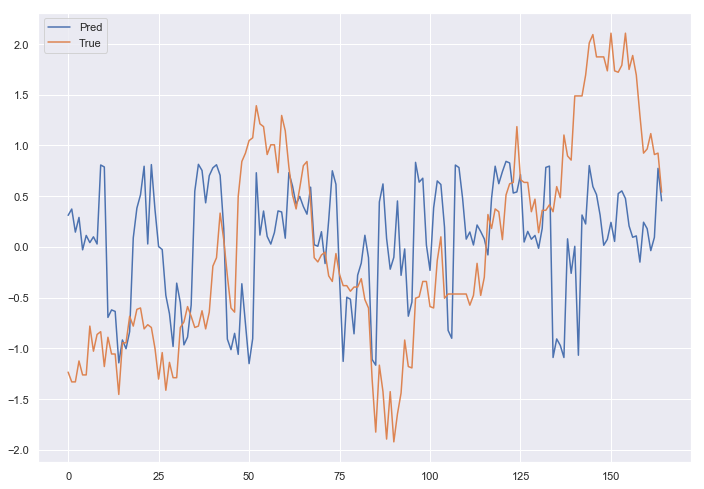

In [11]:
plt.plot(y_pred, label='Pred')
plt.plot(y_test, label='True')
plt.legend()

In [14]:
rms = sqrt(mean_squared_error(y_test, y_pred))
rms, np.mean(y_test), np.mean(y_pred)

(1.045764671751276, -6.935813e-08, 0.05422535453542672)